In [8]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from combat.pycombat import pycombat
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc
from scipy.stats import ttest_ind

In [40]:
# Define global variables for the analysis

# Define the path to the data
phospho_matrix = 'C:/Users/plutzer/Box/CellBio-MajorLab/Users/Isaac/Experiments/013_NEKs_phospho/Analysis/Combined/Phospho/report.pr_matrix.tsv'
protein_matrix = 'C:/Users/plutzer/Box/CellBio-MajorLab/Users/Isaac/Experiments/013_NEKs_phospho/Analysis/Combined/WC/report.pg_matrix.tsv'

# Database path
database_path = 'C:/Users/plutzer/Box/CellBio-MajorLab/Users/Isaac/Experiments/013_NEKs_phospho/Analysis/Combined/Human_sp_20230119_3AUP00000564.fasta'

# Define an output folder
output_folder_path = 'C:/Users/plutzer/Box/CellBio-MajorLab/Users/Isaac/Experiments/013_NEKs_phospho/Analysis/Combined/Output/'

# Define a pathname or the proximity data
proximity_file_name = '/Users/plutzer/Box/CellBio-MajorLab/Users/Isaac/Experiments/Projects/IDG_pipeline/137_DKs/Annotated_Merged_Output.csv' # desktop path

# Define a dictionary to map column names
columns_mapping = {
    'MA5890_293T_IBP_DMSO_1_Phospho.raw':'DMSO 1',
    'MA5891_293T_IBP_DMSO_2_Phospho.raw':'DMSO 2',
    'MA5892_293T_IBP_DMSO_3_Phospho_20231023164958.raw':'DMSO 3',
    'MA5893_293T_IBP_DMSO_4_Phospho_20231023182154.raw':'DMSO 4',
    'MA5894_293T_IBP_CDDO_1_Phospho_20231023195348.raw':'CDDO 1',
    'MA5895_293T_IBP_CDDO_2_Phospho_20231023212542.raw':'CDDO 2',
    'MA5896_293T_IBP_CDDO_3_Phospho_20231023225736.raw':'CDDO 3',
    'MA5897_293T_IBP_CDDO_4_Phospho_20231024002929.raw':'CDDO 4',
    'MA5898_293T_IBP_dsRed_1_Phospho_20231025225323.raw':'dsRed 1',
    'MA5899_293T_IBP_dsRed_2_Phospho_20231026002524.raw':'dsRed 2',
    'MA5900_293T_IBP_dsRed_3_Phospho_20231026015719.raw':'dsRed 3',
    'MA5901_293T_IBP_dsRed_4_Phospho_20231026032913.raw':'dsRed 4',
    'MA5914_293T_IBP_AKT1_1_Phospho.raw':'AKT1 1',
    'MA5915_293T_IBP_AKT1_2_Phospho.raw':'AKT1 2',
    'MA5916_293T_IBP_AKT1_3_Phospho.raw':'AKT1 3',
    'MA5917_293T_IBP_AKT1_4_Phospho.raw':'AKT1 4',
    'MA5922_293T_IBP_BRSK2_1_Phospho.raw':'BRSK2 1',
    'MA5923_293T_IBP_BRSK2_2_Phospho.raw':'BRSK2 2',
    'MA5924_293T_IBP_BRSK2_3_Phospho.raw':'BRSK2 3',
    'MA5925_293T_IBP_BRSK2_4_Phospho.raw':'BRSK2 4'
}

quant_prefix = 'D:\\MaxQuant_Searches\\Major lab\\Isaac\\013_Phospho_DIA_Kingfisher\\Kinases\\Phospho\\'

quant_cols_order = [
    'DMSO 1',
    'DMSO 2',
    'DMSO 3',
    'DMSO 4',
    'CDDO 1',
    'CDDO 2',
    'CDDO 3',
    'CDDO 4',
    'dsRed 1',
    'dsRed 2',
    'dsRed 3',
    'dsRed 4',
    'AKT1 1',
    'AKT1 2',
    'AKT1 3',
    'AKT1 4',
    'BRSK2 1',
    'BRSK2 2',
    'BRSK2 3',
    'BRSK2 4'
]

comparisons = {
    'CDDO':[['DMSO 1','DMSO 2','DMSO 3','DMSO 4'],['CDDO 1','CDDO 2','CDDO 3','CDDO 4']],
    'AKT1':[['dsRed 1','dsRed 2','dsRed 3','dsRed 4'],['AKT1 1','AKT1 2','AKT1 3','AKT1 4']],
    'BRSK2':[['dsRed 1','dsRed 2','dsRed 3','dsRed 4'],['BRSK2 1','BRSK2 2','BRSK2 3','BRSK2 4']]
}

baits = ['AKT1','BRSK2','KEAP1','NFE2L2','CUL3']


In [10]:
# If the output directory doesn't exist, create it
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

In [11]:
# Code for mixing correction:
def correct_mixing(dataset,columns):
    data = dataset[columns]
    sums = np.sum(data)
    corrected = data/(sums/np.mean(sums))
    return corrected

In [12]:
# Read in the phospho data
phospho = pd.read_csv(phospho_matrix,sep='\t')

# Parse the database file line by line
# Create a dictionary to store the protein sequences
protein_sequences = {}

# Open the database file
with open(database_path,'r') as f:
    # Iterate over the lines in the file
    for line in f:
        # Check if the line is a header line
        if line[0] == '>':
            # If it is, parse the line to get the protein name
            protein_name = line.split('|')[1]
        else:
            # If it isn't a header line, it's part of the sequence
            # Add the sequence to the sequence string
            # Check if the protein name is already in the dictionary
            if protein_name in protein_sequences:
                # If it is, add the sequence to the existing sequence
                protein_sequences[protein_name] += line.strip()
            else:
                # If it isn't, initialize the sequence
                protein_sequences[protein_name] = line.strip()

# Create a function that takes in a protein name and peptide sequence and fin


In [13]:
def find_peptide_start(protein_name, peptide_sequence):
    start_positions = []
    if protein_name in protein_sequences:
        protein_sequence = protein_sequences[protein_name]
        for i in range(len(protein_sequence) - len(peptide_sequence) + 1):
            if protein_sequence[i:i+len(peptide_sequence)] == peptide_sequence:
                start_positions.append(i)
        if len(start_positions) == 0:
            print("Peptide sequence cannot be mapped to the protein sequence.")
        # elif len(start_positions) > 1:
        #     a = 0
        # else:
        #     a = 0
        #     #print("Peptide sequence starts at position:", start_positions[0])
    else:
        print("Protein name not found in the protein sequences dictionary.")
    return start_positions

# Now need a second function that finds the position of the modified residue within the peptide sequence and adds it to the start position
def find_mod_position(mod_sequence, start_positions):
    # Clean up the mod sequence

    # Replace (UniMod:21) with *
    mod_sequence = re.sub(r'\(UniMod:21\)', '*', mod_sequence)

    # Remove all text that is inside of parentheses
    mod_sequence = re.sub(r'\([^()]*\)', '', mod_sequence)

    

    mod_positions = []
    for start in start_positions:
        mod_positions += list((np.array([len(item) for item in mod_sequence.split('*')[:-1]]) + start).astype(str))
    return ';'.join(mod_positions)

# Create a function that creates an index for a row by combining the Protein.ID and modified_position columns with the residue that is modified.
def create_index(id,mod_sequence,mod_position):
    mod_res = mod_sequence.split('(UniMod:21)')[0][-1]
    return id + '_' + mod_res + mod_position



In [14]:
# Split the Protein.Group column of the phospho dataframe to get the first protein id separated by ';'
phospho['first_id'] = phospho['Protein.Group'].str.split(';').str[0]

# Apply the find_peptide_start function to the first_id column and peptide sequence column
phospho['start_position'] = phospho.apply(lambda row: find_peptide_start(row['first_id'], row['Stripped.Sequence']), axis=1)

# Apply the find_mod_position function to the stripped sequence column and start position column
phospho['mod_position'] = phospho.apply(lambda row: find_mod_position(row['Modified.Sequence'], row['start_position']), axis=1)

# Filter the phospho dataframe to only include rows where the mod_position column is not empty and doesn't contain a semicolon
phospho = phospho[phospho['mod_position'] != '']
phospho = phospho[~phospho['mod_position'].str.contains(';')]

# Create a column for the first Gene in the Genes column
phospho['first_gene'] = phospho['Genes'].str.split(';').str[0]

# Create an index using the create_index function
phospho['index'] = phospho.apply(lambda row: create_index(row['first_gene'], row['Modified.Sequence'], row['mod_position']), axis=1)

# Set the index of the phospho dataframe to the index column
phospho.set_index('index',inplace=True)

# Save the phospho dataframe to a csv file
phospho.to_csv(output_folder_path + 'indexed_phospho.csv')

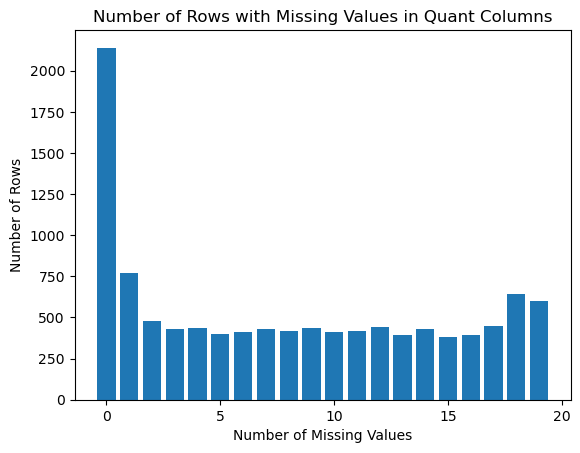

In [15]:
# Now time to preprocess this data.

# For any columns that contain the quant prefix, remove the prefix
quant_cols = [col for col in phospho.columns if quant_prefix in col]
for col in quant_cols:
    phospho.rename(columns={col:col.replace(quant_prefix,'')},inplace=True)

# Change the columns using the columns mapping dictionary
phospho.rename(columns=columns_mapping,inplace=True)

# Perform mixing correction on the phospho dataframe
phospho_corrected = phospho.copy()

phospho_corrected[quant_cols_order] = correct_mixing(phospho_corrected,quant_cols_order)


# Count the number of missing values in each row for the quant columns
missing_values_count = phospho_corrected[quant_cols_order].isnull().sum(axis=1)

# Count the number of rows with each number of missing values
missing_values_counts = missing_values_count.value_counts().sort_index()

# Create a bar plot
plt.bar(missing_values_counts.index, missing_values_counts.values)

# Make the x axis ticks integers
plt.locator_params(axis='x', integer=True)

# Set the labels and title
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.title('Number of Rows with Missing Values in Quant Columns')

# Save the figure
plt.savefig(output_folder_path + 'missing_values.png',dpi=300)

# Save the corrected phospho dataframe to a csv file
phospho_corrected.to_csv(output_folder_path + 'indexed_phospho_mixcorrected.csv')

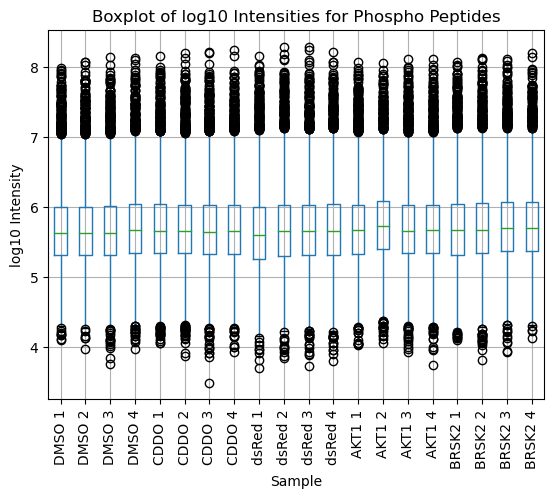

In [16]:
# Now perform a log10 transformation on the corrected phospho dataframe
phospho_corrected_log10 = phospho_corrected.copy()

phospho_corrected_log10[quant_cols_order] = np.log10(phospho_corrected_log10[quant_cols_order] + 1)

# Save the corrected phospho dataframe to a csv file
phospho_corrected_log10.to_csv(output_folder_path + 'indexed_phospho_mixcorrected_log10.csv')

# Create a boxplot of the corrected phospho dataframe
phospho_corrected_log10.boxplot(column=quant_cols_order)

# Rotate the x axis labels
plt.xticks(rotation=90)

plt.ylabel('log10 Intensity')
plt.title('Boxplot of log10 Intensities for Phospho Peptides')
plt.xlabel('Sample')

# Also perform a log2 transformation on the corrected phospho dataframe
phospho_corrected_log2 = phospho_corrected.copy()

phospho_corrected_log2[quant_cols_order] = np.log2(phospho_corrected_log2[quant_cols_order] + 1)




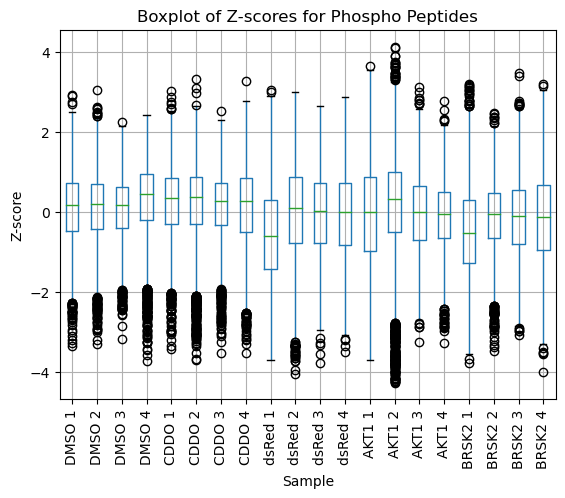

In [17]:
# Now z-score normalize the corrected phospho dataframe
phospho_corrected_zscore = phospho_corrected_log10.copy()

phospho_corrected_zscore[quant_cols_order] = phospho_corrected_zscore[quant_cols_order].apply(lambda x: (x - np.mean(x)) / np.std(x), axis=1)

# Create a boxplot of the corrected phospho dataframe
phospho_corrected_zscore.boxplot(column=quant_cols_order)

# Rotate the x axis labels
plt.xticks(rotation=90)

plt.ylabel('Z-score')
plt.title('Boxplot of Z-scores for Phospho Peptides')
plt.xlabel('Sample')

# Save the figure
plt.savefig(output_folder_path + 'zscore_boxplot.png',dpi=300)

# Save the corrected phospho dataframe to a csv file
phospho_corrected_zscore.to_csv(output_folder_path + 'indexed_phospho_mixcorrected_zscore.csv')



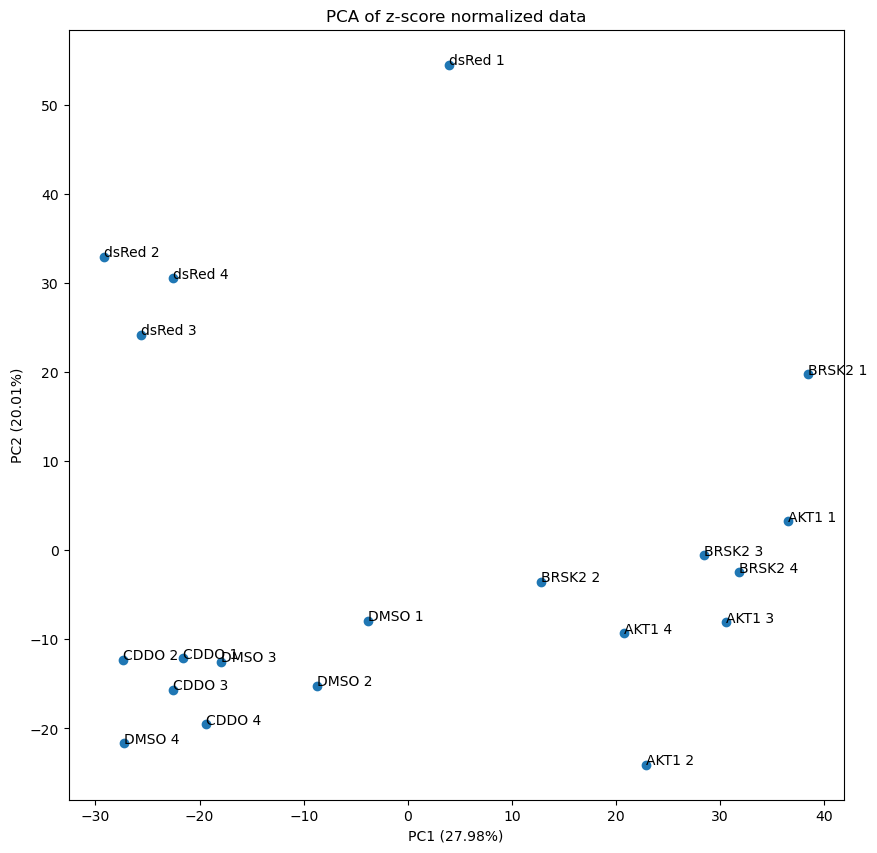

In [18]:
# Make a PCA plot of the z-score normalized data

# Filter the data to only include the quant columns
zscore_quant = phospho_corrected_zscore[quant_cols_order].dropna()

# Each column should be a point on the PCA plot

# Make a PCA object
pca = PCA(n_components=2)

pca.fit(zscore_quant.transpose())

# Transform the data
pca_data = pca.transform(zscore_quant.transpose())

# Make a dataframe from the pca_data
pca_df = pd.DataFrame(pca_data, index=quant_cols_order, columns=['PC1','PC2'])

# Plot the PCA data
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(pca_df['PC1'], pca_df['PC2'])

# Add annotations of the points
for i, txt in enumerate(pca_df.index):
    ax.annotate(txt, (pca_df['PC1'][i], pca_df['PC2'][i]))

# In the axes labels include the percent of variance explained by each PC
ax.set_xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100,2)) + '%)')
ax.set_ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100,2)) + '%)')
ax.set_title('PCA of z-score normalized data')
fig.savefig(output_folder_path + 'PCA.png')


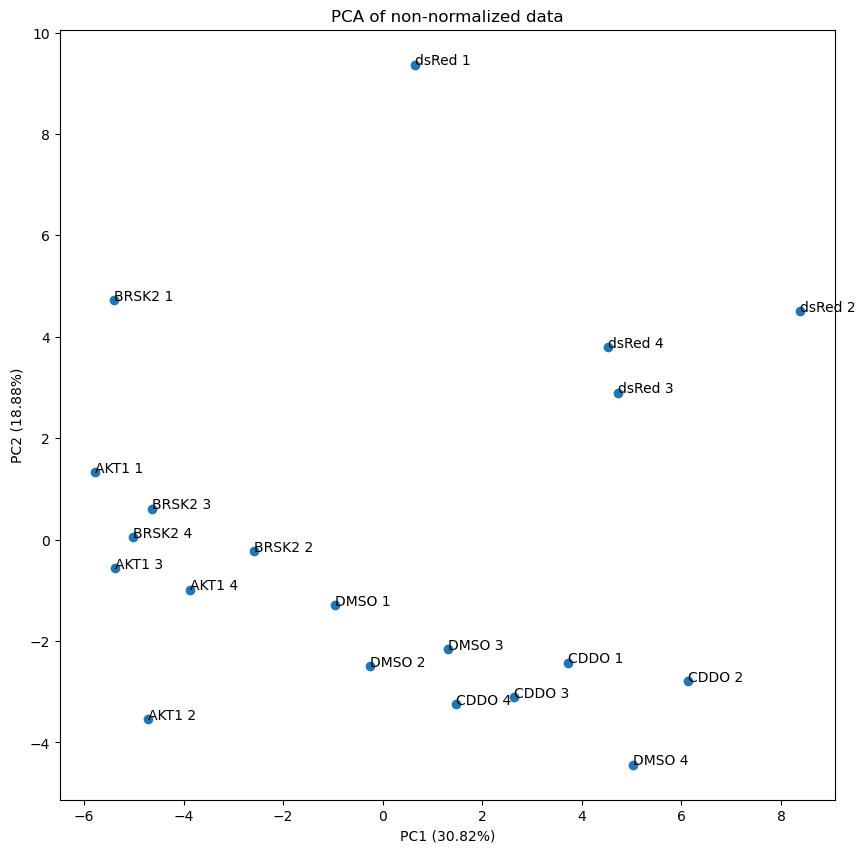

In [19]:
# Create another PCA plot of the non-normalized data

# Filter the data to only include the quant columns
quant = phospho_corrected_log10[quant_cols_order].dropna()

# Each column should be a point on the PCA plot

# Make a PCA object
pca = PCA(n_components=2)

pca.fit(quant.transpose())

# Transform the data
pca_data = pca.transform(quant.transpose())

# Make a dataframe from the pca_data
pca_df = pd.DataFrame(pca_data, index=quant_cols_order, columns=['PC1','PC2'])

# Plot the PCA data
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(pca_df['PC1'], pca_df['PC2'])

# Add annotations of the points
for i, txt in enumerate(pca_df.index):
    ax.annotate(txt, (pca_df['PC1'][i], pca_df['PC2'][i]))

# In the axes labels include the percent of variance explained by each PC
ax.set_xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100,2)) + '%)')
ax.set_ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100,2)) + '%)')

ax.set_title('PCA of non-normalized data')
fig.savefig(output_folder_path + 'PCA_nonnormalized.png')


In [20]:
# Make a correlation matrix between all of the observations
corr = phospho_corrected_zscore[quant_cols_order].transpose().corr()

# Replace infinite and NaN values with a finite value
corr = corr.replace([np.inf, -np.inf, np.nan], 0)

link = shc.linkage(corr, method='average', metric='euclidean')

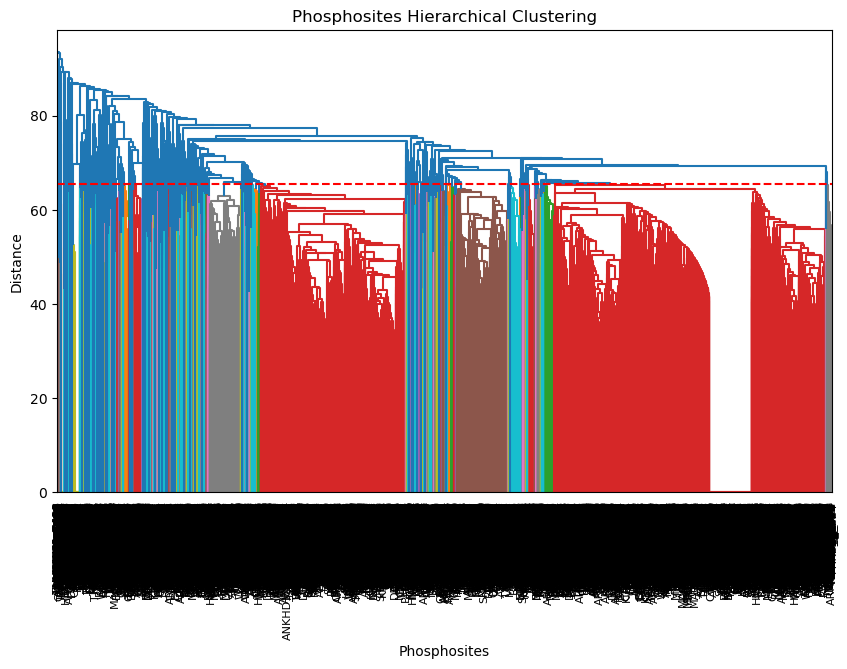

In [21]:
# Create a dendrogram
plt.figure(figsize=(10, 6))
shc.dendrogram(link, labels=corr.index, leaf_rotation=90, leaf_font_size=8)
plt.title('Phosphosites Hierarchical Clustering')
plt.xlabel('Phosphosites')
plt.ylabel('Distance')

# Add a horizontal line
plt.axhline(y=0.7*max(link[:,2]), color='r', linestyle='--')

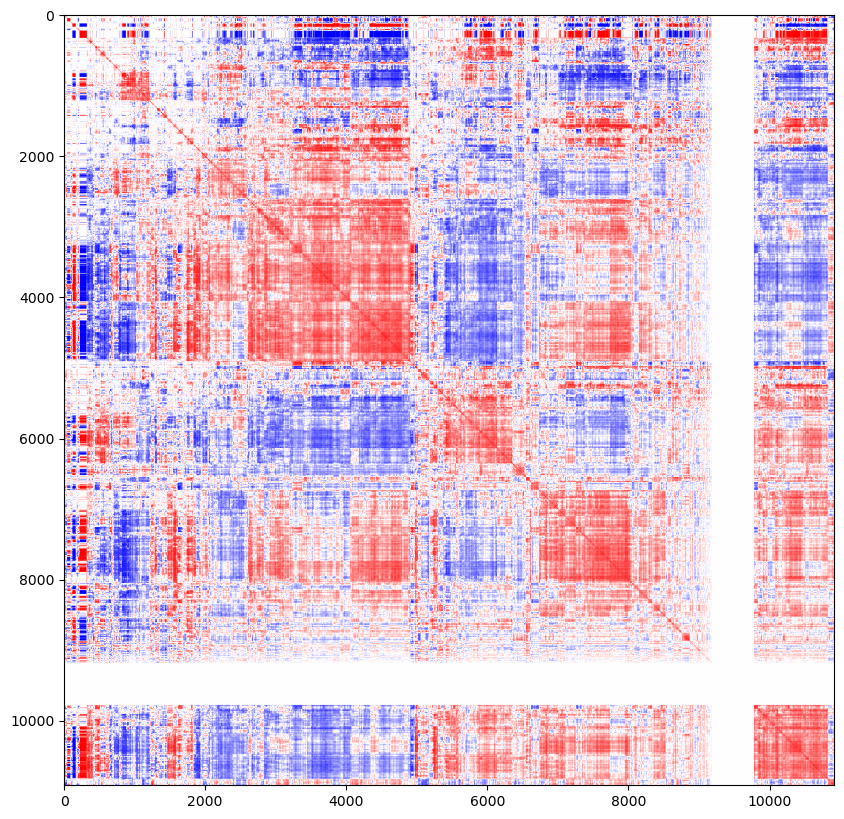

In [28]:
threshold_height = 0.7*max(link[:,2])
corr_clusters = shc.fcluster(link, threshold_height, criterion='distance')

# Get the ordering of the dendrogram leaves
sorted_indices = shc.dendrogram(link, no_plot=True)['leaves']

# Sort the correlation matrix by the dendrogram ordering. Corr is a pandas dataframe so we can use the .values attribute to get the underlying numpy array
sorted_correlation_matrix = corr.iloc[sorted_indices, sorted_indices]

# Visualize the sorted correlation matrix
plt.figure(figsize=(10, 10))
plt.imshow(sorted_correlation_matrix.values, cmap='bwr')

In [23]:
# phospho_corrected_log2

# Define a function that can be used with apply to perform the t-test
def ttest(row,key):
    return ttest_ind(list(row[comparisons[key][1]].dropna()), list(row[comparisons[key][0]].dropna())).pvalue

# Compute the log2 fold changes for each comparison
for key in comparisons.keys():
    # Use the log2 fold change of the means
    phospho_corrected_log2['log2FC_' + key] = np.mean(phospho_corrected_log2[comparisons[key][1]], axis=1) - np.mean(phospho_corrected_log2[comparisons[key][0]], axis=1)
    
    # Perform the t-test
    phospho_corrected_log2['pval_' + key] = phospho_corrected_log2.apply(lambda row: ttest(row,key), axis=1)

# Save the dataframe to a csv file
phospho_corrected_log2.to_csv(output_folder_path + 'indexed_phospho_mixcorrected_log2.csv')


C:\Users\plutzer\AppData\Local\Temp\ipykernel_38304\3193723584.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return ttest_ind(list(row[comparisons[key][1]].dropna()), list(row[comparisons[key][0]].dropna())).pvalue
C:\Users\plutzer\AppData\Local\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\plutzer\AppData\Local\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\plutzer\AppData\Local\Temp\ipykernel_38304\3193723584.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results ma

In [24]:
# Now add the p-values and log2 fold changes to the zscore dataframe
combined_zscore_with_fc = phospho_corrected_zscore.copy()

for key in comparisons.keys():
    combined_zscore_with_fc['log2FC_' + key] = phospho_corrected_log2['log2FC_' + key]
    combined_zscore_with_fc['pval_' + key] = phospho_corrected_log2['pval_' + key]

# Now add the cluster labels to the dataframe
combined_zscore_with_fc['cluster'] = corr_clusters

# Save the combined_zscore_with_fc dataframe to a csv file
combined_zscore_with_fc.to_csv(output_folder_path + 'combined.csv')

In [37]:
# Create outputs that can be used for enrichment analysis by the kinase library

# for key in comparisons.keys():
#     df = combined_zscore_with_fc[['Sequence window','log2FC_' + key,'pval_' + key]]    
#     # Change the sequence window column to only include the first element ';' of the delimited string
#     df['Sequence window'] = df['Sequence window'].apply(lambda x: x.split(';')[0])
#     df.to_csv(output_folder_path + key + '_enrichment_input.txt', sep = '\t', index=False)


def get_motif(row):
    return protein_sequences[row['first_id']][int(row['mod_position'])-8:int(row['mod_position'])+7]

for key  in comparisons.keys():
    df = combined_zscore_with_fc[['first_id','mod_position','log2FC_' + key,'pval_' + key]]

    # Filter the dataframe to only include rows that don't have nan for the pvalue and log2FC
    df = df[~df['pval_' + key].isnull()]
    df = df[~df['log2FC_' + key].isnull()]

    df['motif'] = df.apply(lambda row: get_motif(row), axis=1)
    final_df = df[['motif','log2FC_' + key,'pval_' + key]]
    final_df.to_csv(output_folder_path + key + '_enrichment_input.txt', sep = '\t', index=False)

In [31]:
combined_zscore_with_fc.columns

Index(['Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes',
       'First.Protein.Description', 'Proteotypic', 'Stripped.Sequence',
       'Modified.Sequence', 'Precursor.Charge', 'Precursor.Id', 'DMSO 1',
       'DMSO 2', 'DMSO 3', 'DMSO 4', 'CDDO 1', 'CDDO 2', 'CDDO 3', 'CDDO 4',
       'dsRed 1', 'dsRed 2', 'dsRed 3', 'dsRed 4', 'AKT1 1', 'AKT1 2',
       'AKT1 3', 'AKT1 4', 'BRSK2 1', 'BRSK2 2', 'BRSK2 3', 'BRSK2 4',
       'first_id', 'start_position', 'mod_position', 'first_gene',
       'log2FC_CDDO', 'pval_CDDO', 'log2FC_AKT1', 'pval_AKT1', 'log2FC_BRSK2',
       'pval_BRSK2', 'cluster'],
      dtype='object')

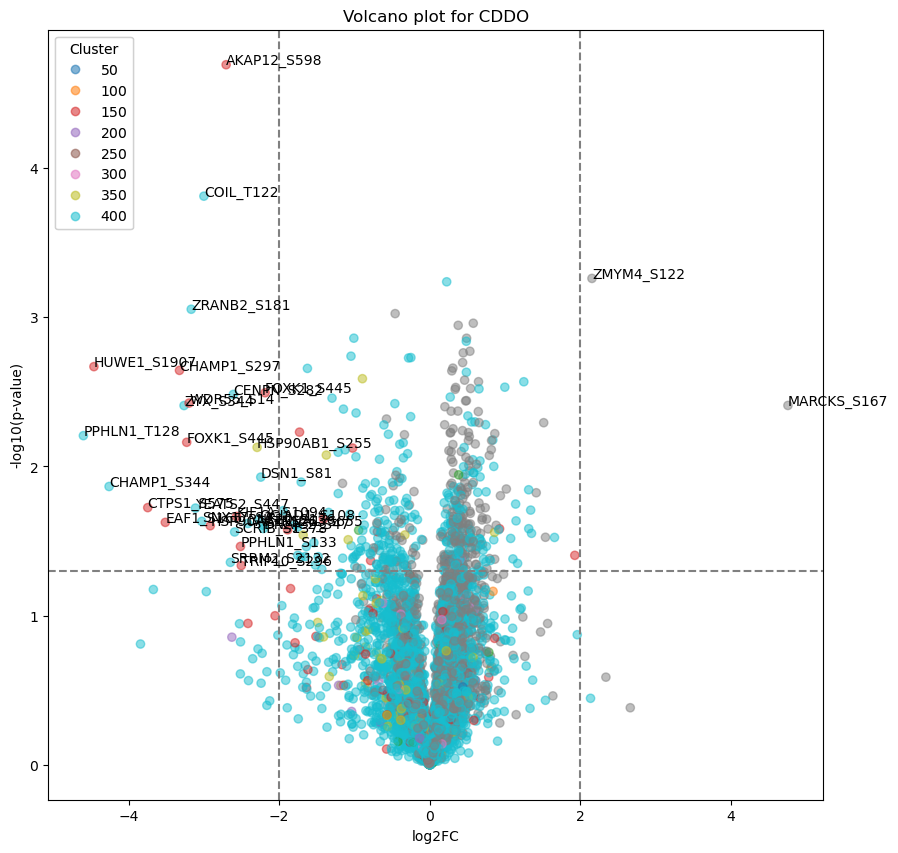

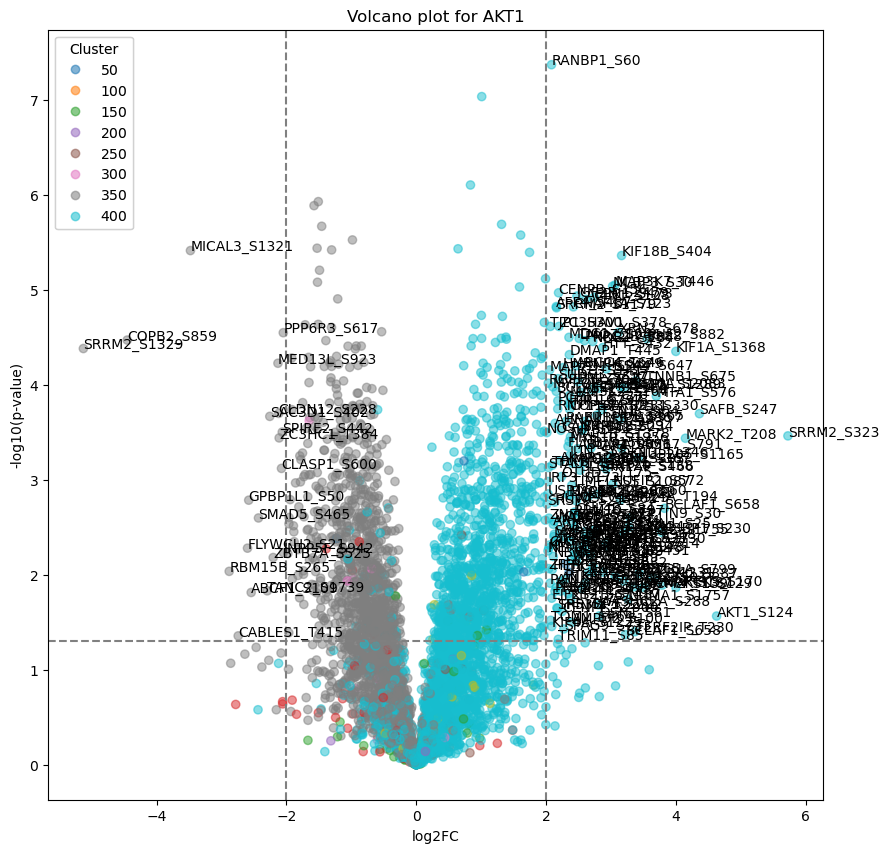

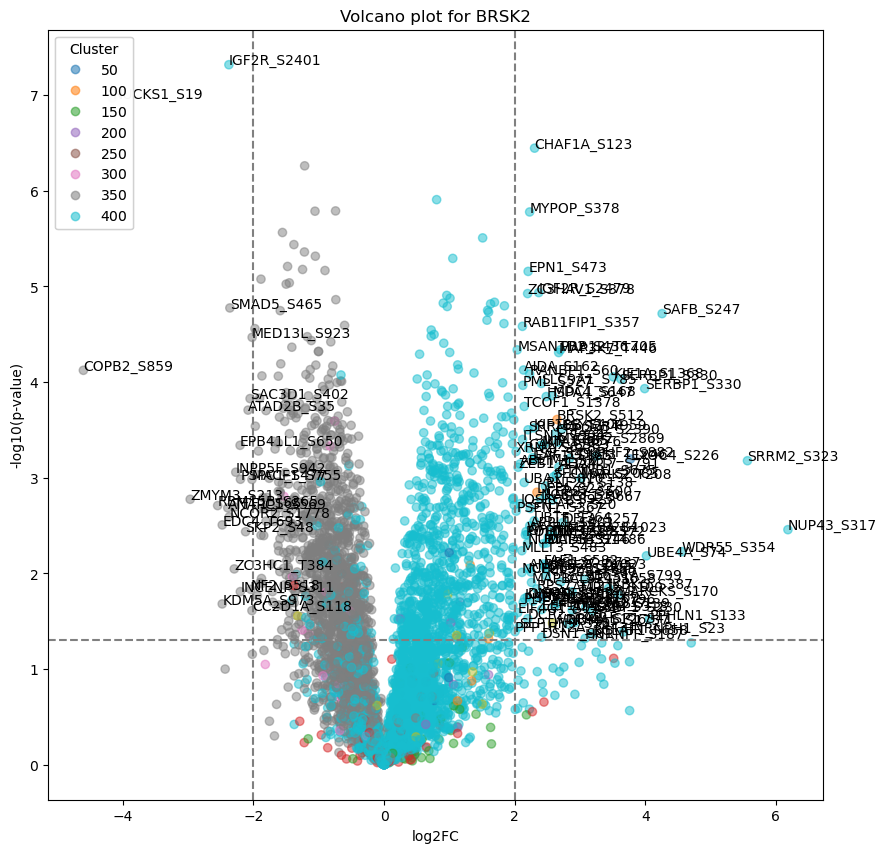

In [26]:
# Create volcano plots for each comparison

for key in comparisons.keys():
    # Make a volcano plot
    fig, ax = plt.subplots(figsize=(10,10))
    # Use default colors for the clusters
    # Color the points on the volcano plot by cluster - use  the colors list
    # Don't do it with the for loop because it affects the order of the points
    scatter = ax.scatter(combined_zscore_with_fc['log2FC_' + key], -np.log10(combined_zscore_with_fc['pval_' + key]), c=combined_zscore_with_fc['cluster'], cmap='tab10', alpha=0.5)

    
    # Add a line for a significance threshold
    ax.axhline(y=-np.log10(0.05), color='grey', linestyle='--')

    # Add a vertical line for the log2FC threshold of +/- 2
    ax.axvline(x=2, color='grey', linestyle='--')
    ax.axvline(x=-2, color='grey', linestyle='--')

    legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Cluster")
    ax.add_artist(legend1)

    # Add text annotations for all points that are significant and have a log2FC greater than 1
    for i, txt in enumerate(combined_zscore_with_fc.index):
        if combined_zscore_with_fc['pval_' + key][i] < 0.05 and combined_zscore_with_fc['log2FC_' + key][i] > 2:
            ax.annotate(txt, (combined_zscore_with_fc['log2FC_' + key][i], -np.log10(combined_zscore_with_fc['pval_' + key][i])))
        elif combined_zscore_with_fc['pval_' + key][i] < 0.05 and combined_zscore_with_fc['log2FC_' + key][i] < -2:
            ax.annotate(txt, (combined_zscore_with_fc['log2FC_' + key][i], -np.log10(combined_zscore_with_fc['pval_' + key][i])))

    ax.set_xlabel('log2FC')
    ax.set_ylabel('-log10(p-value)')
    ax.set_title('Volcano plot for ' + key)
    fig.savefig(output_folder_path + key + '_volcano.png')

C:\Users\plutzer\AppData\Local\Temp\ipykernel_38304\2843735713.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10,10))


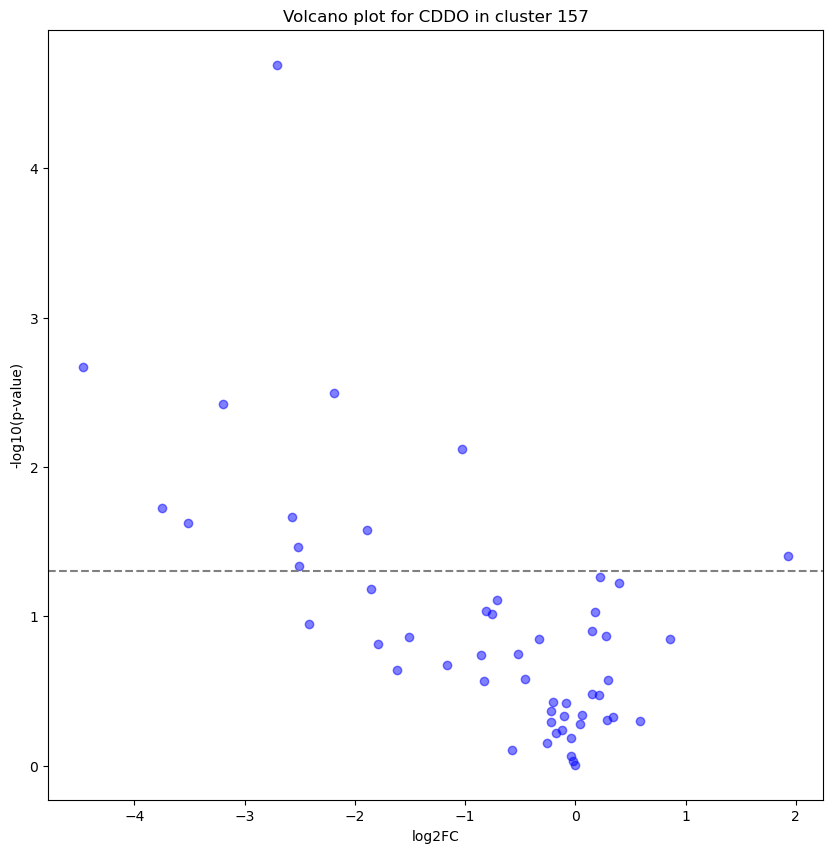

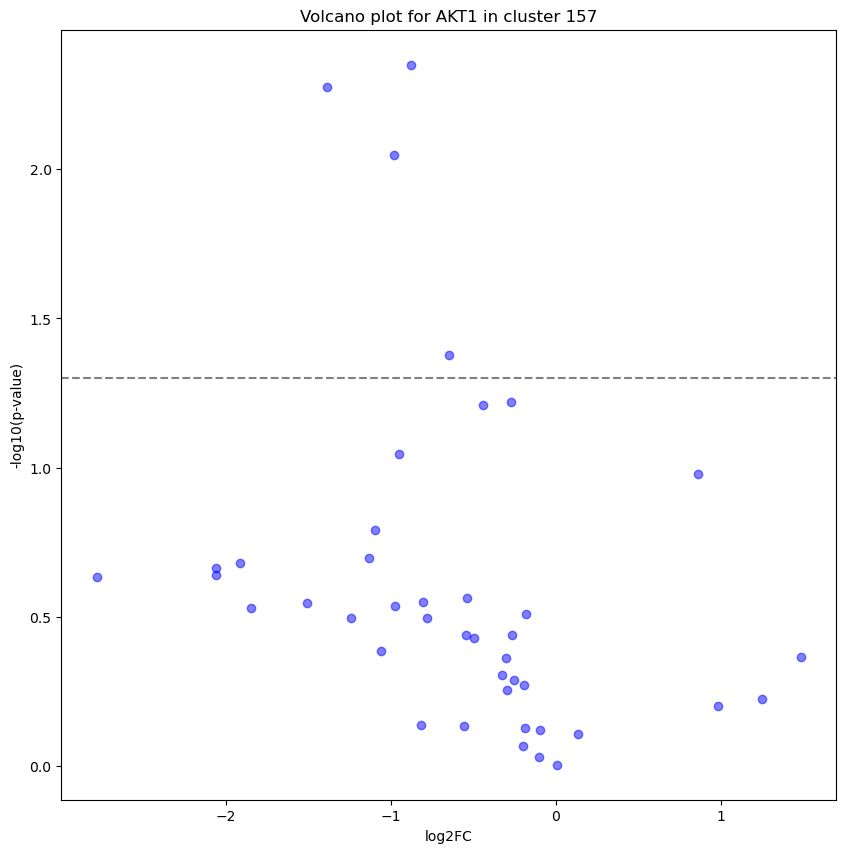

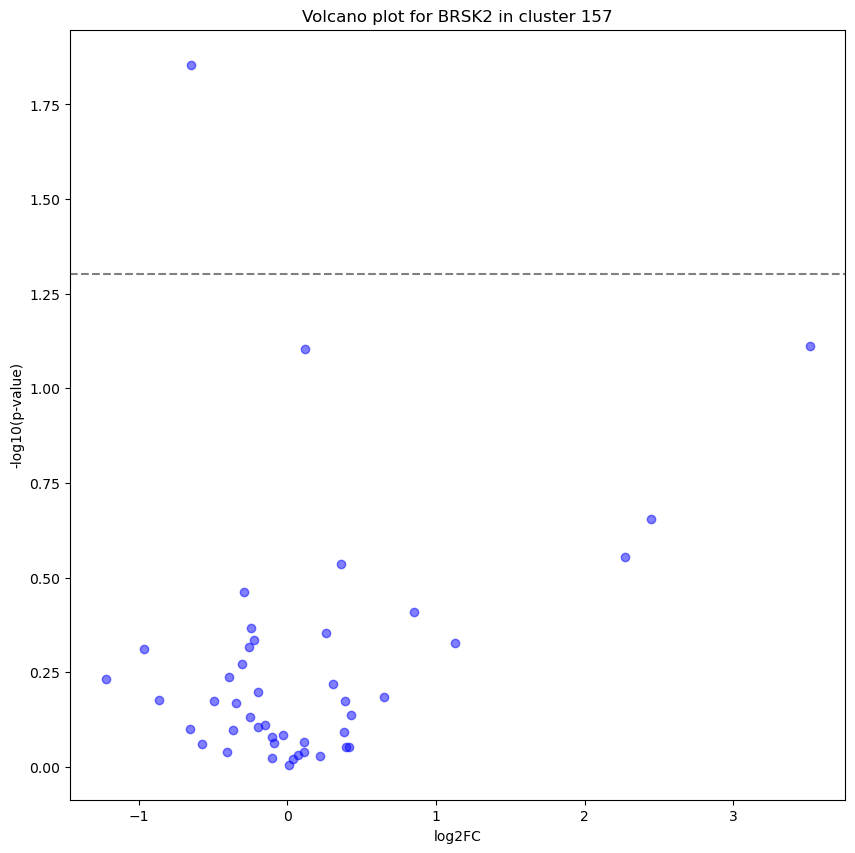

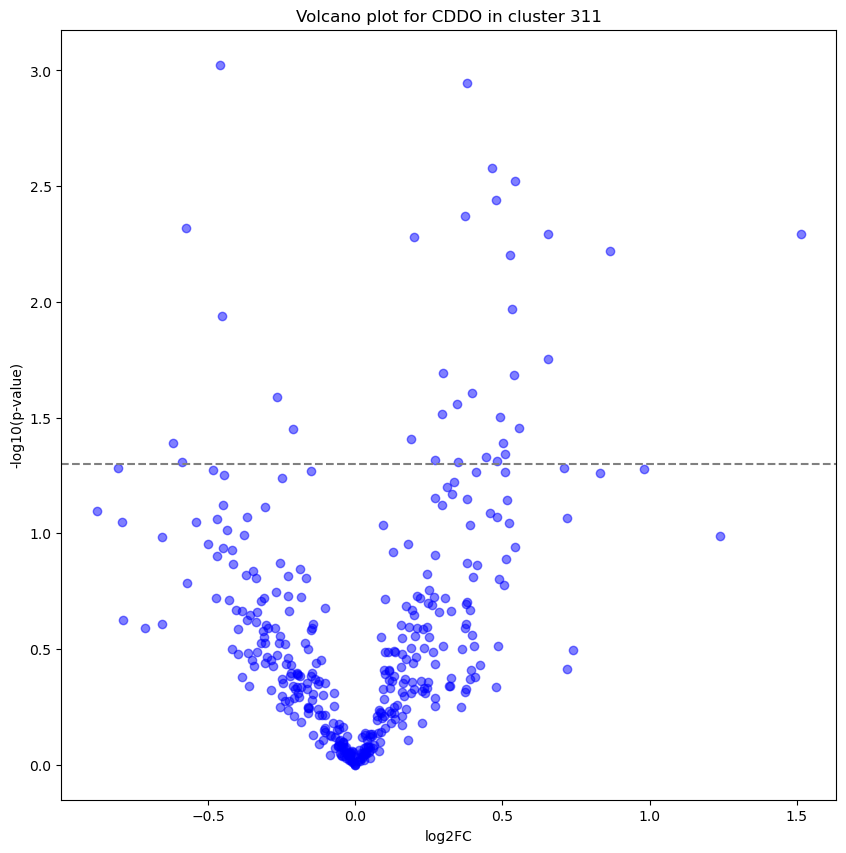

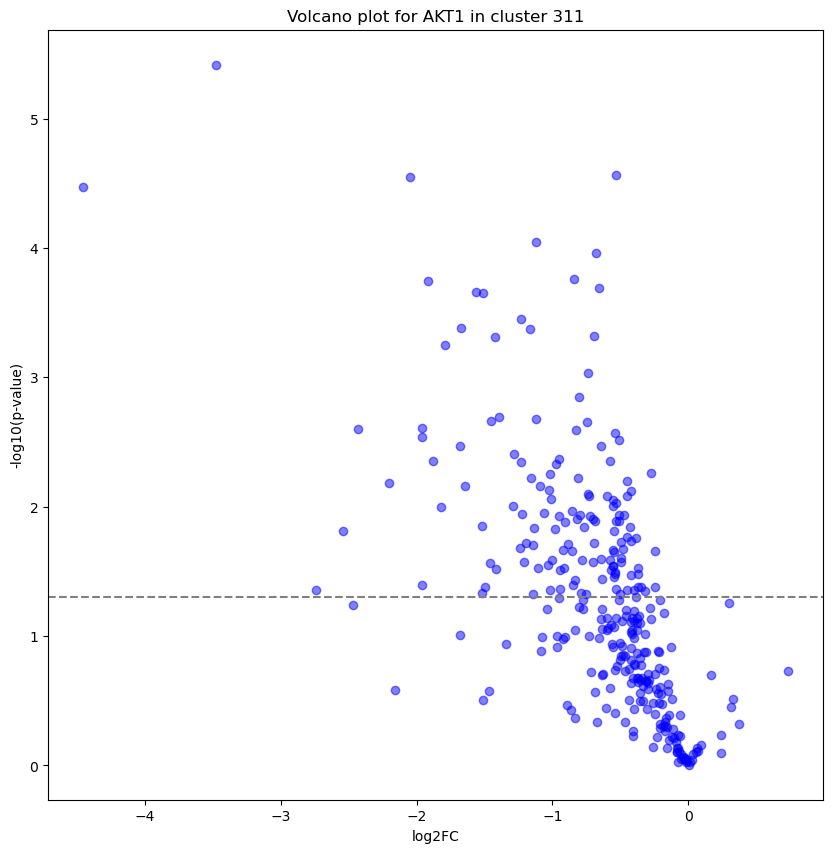

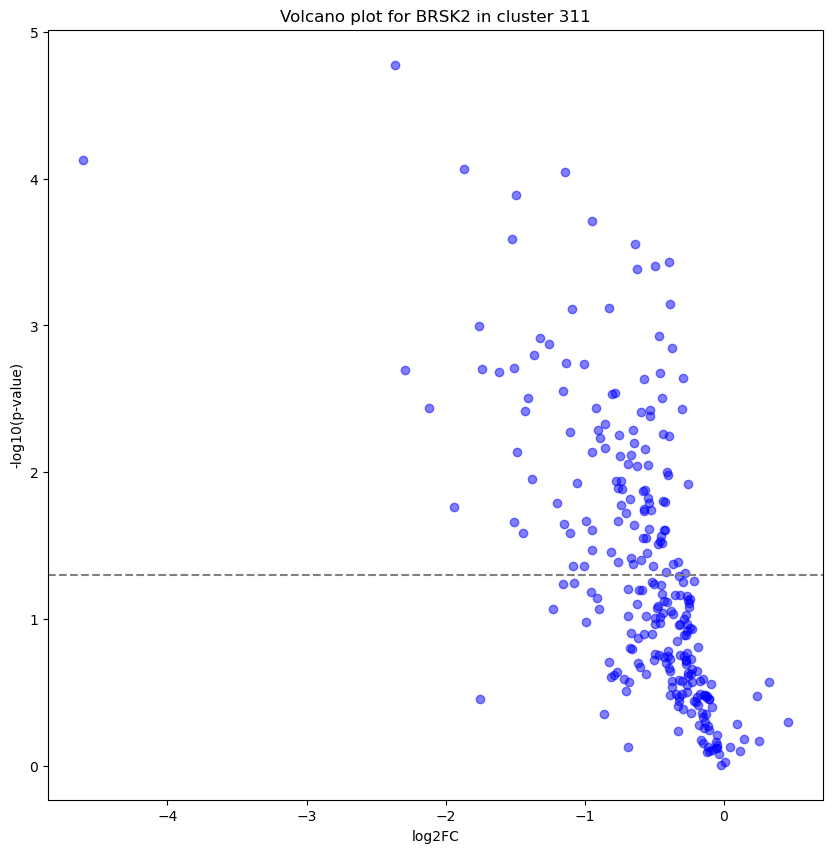

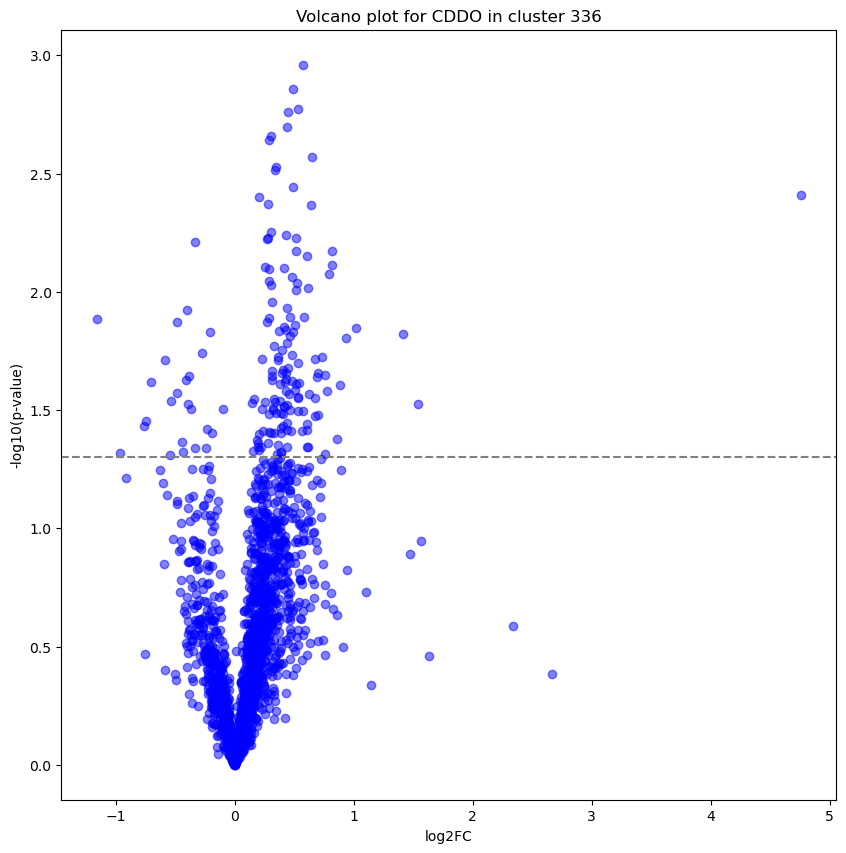

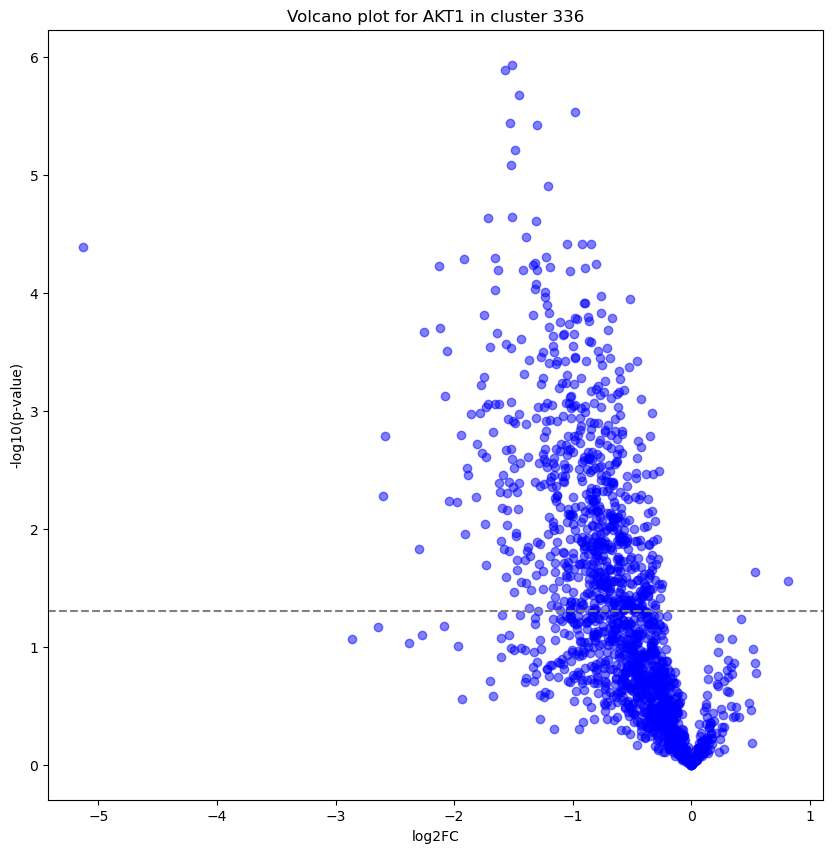

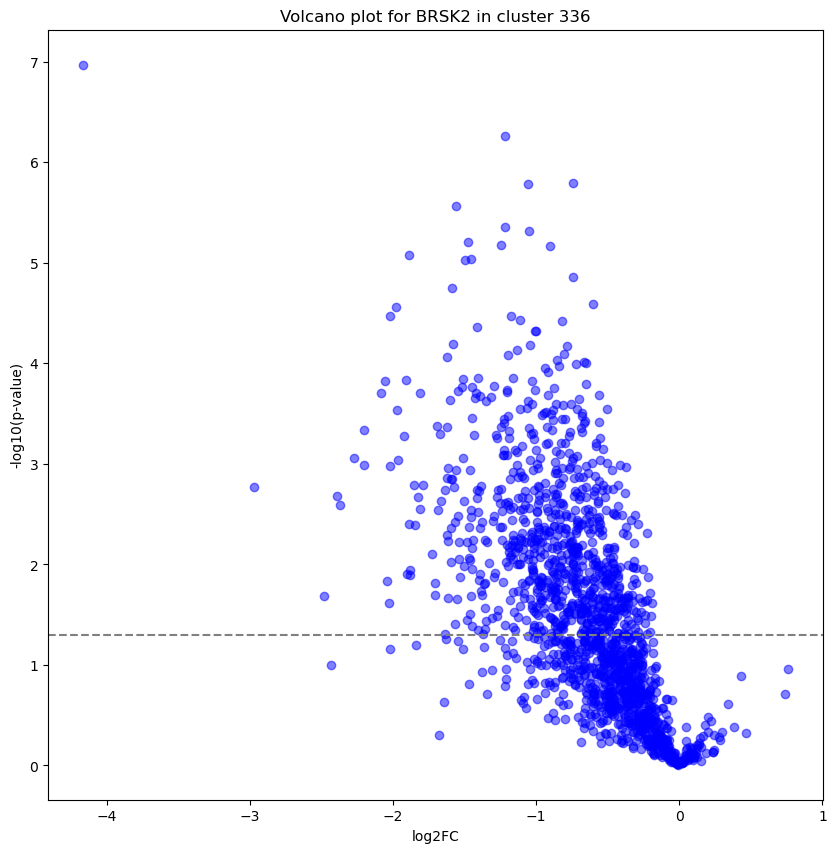

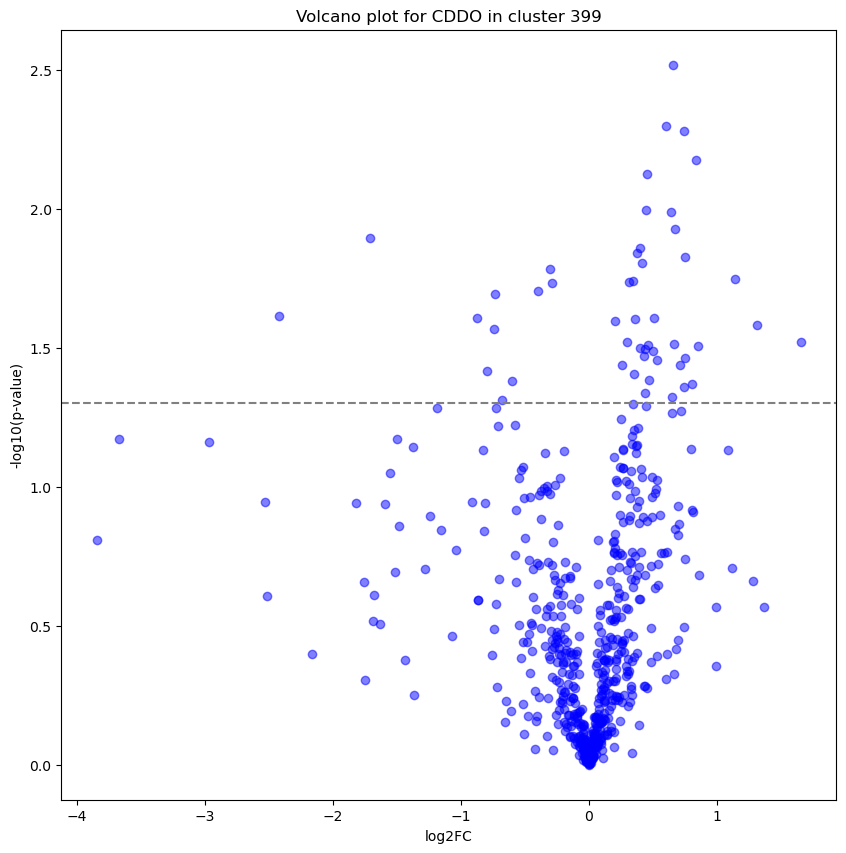

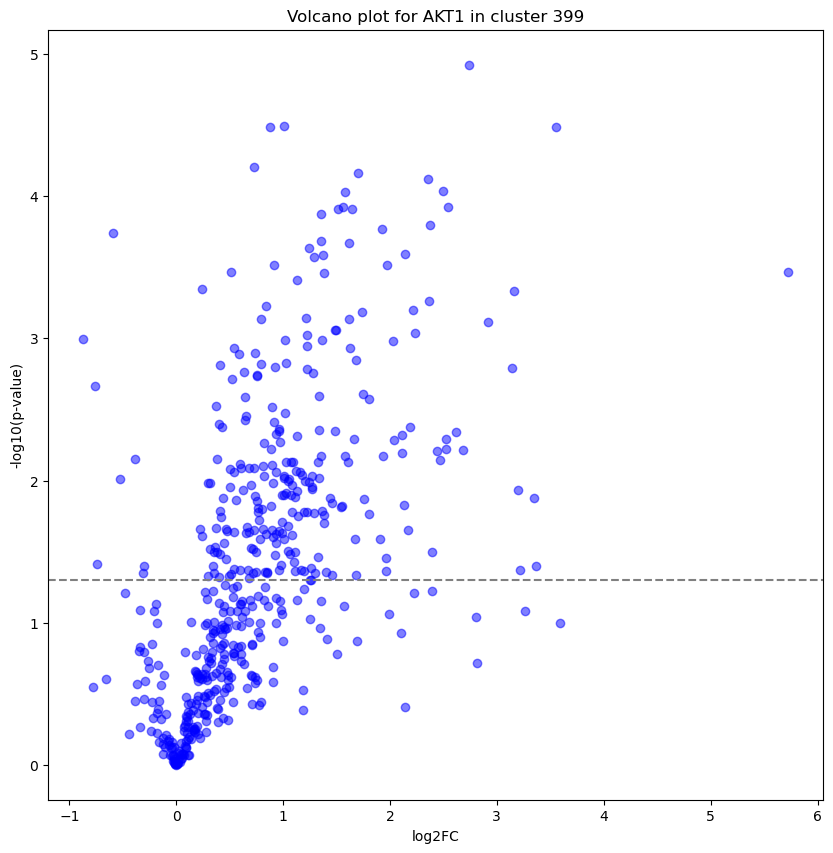

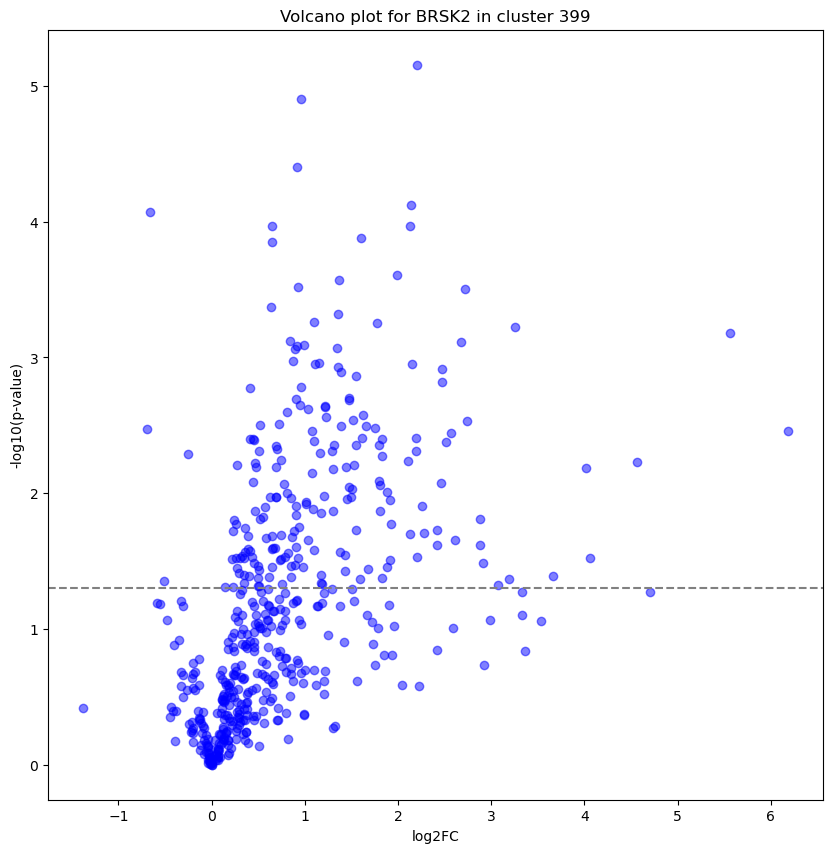

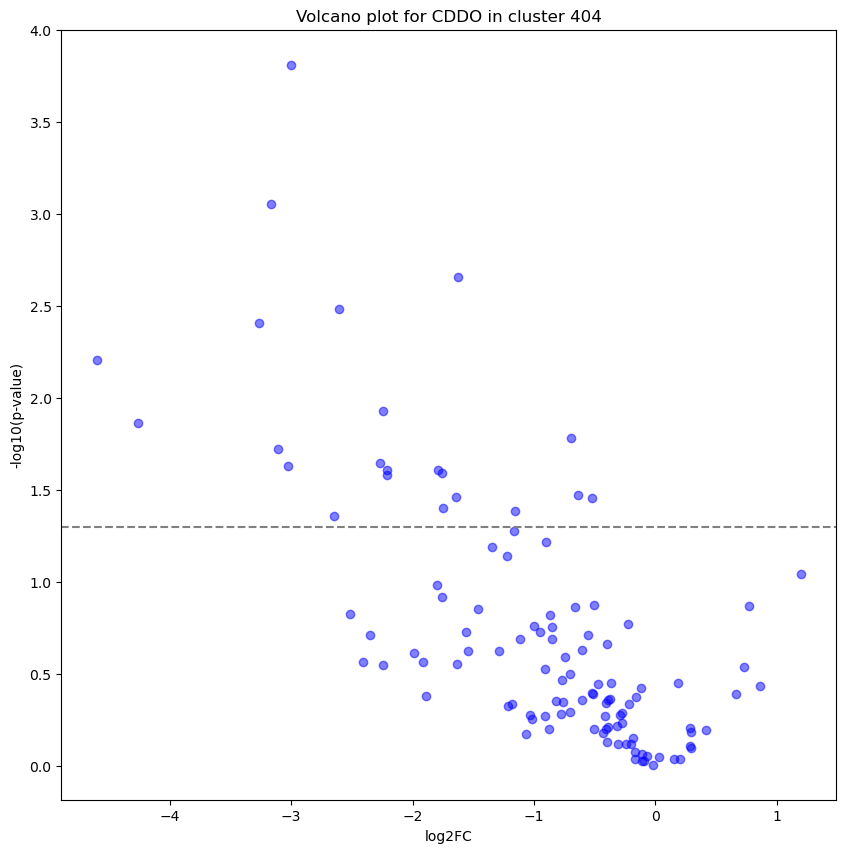

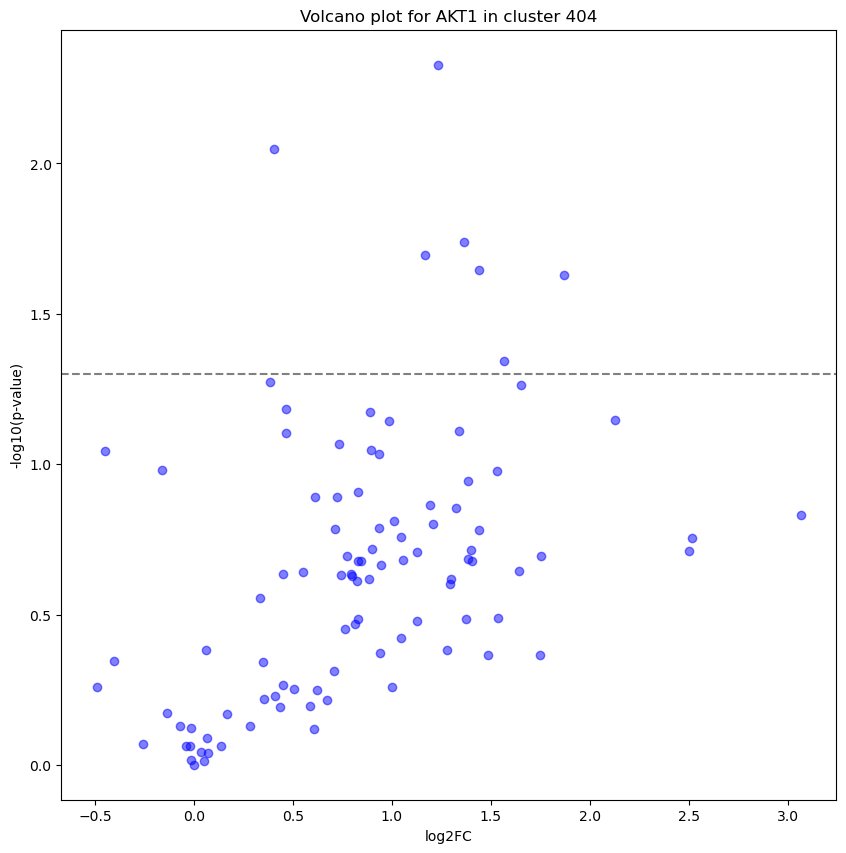

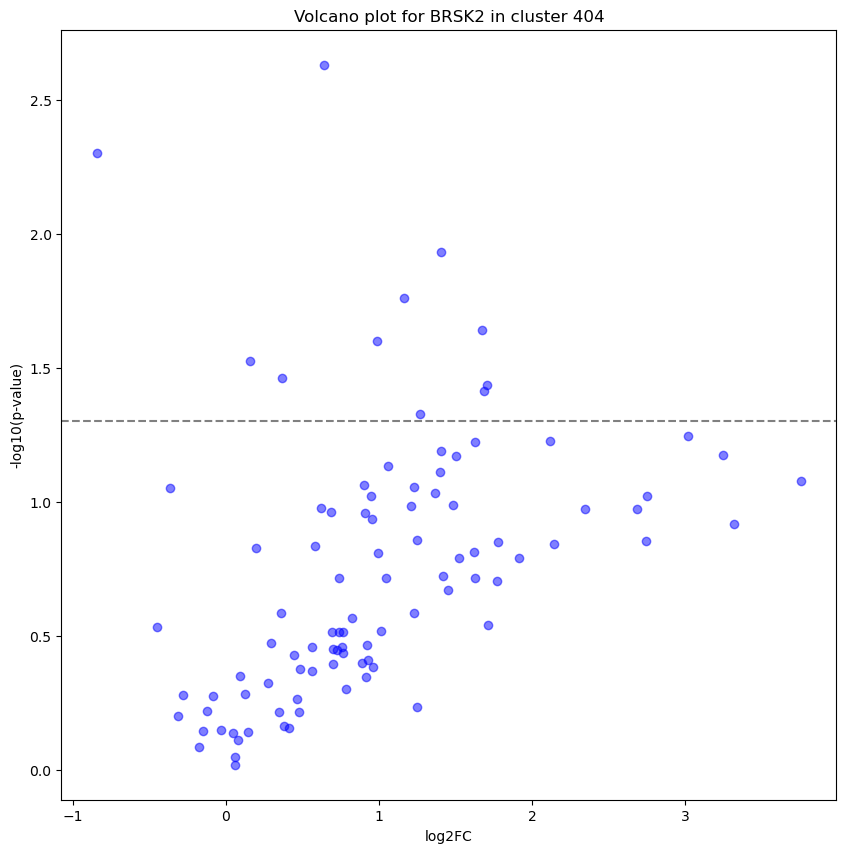

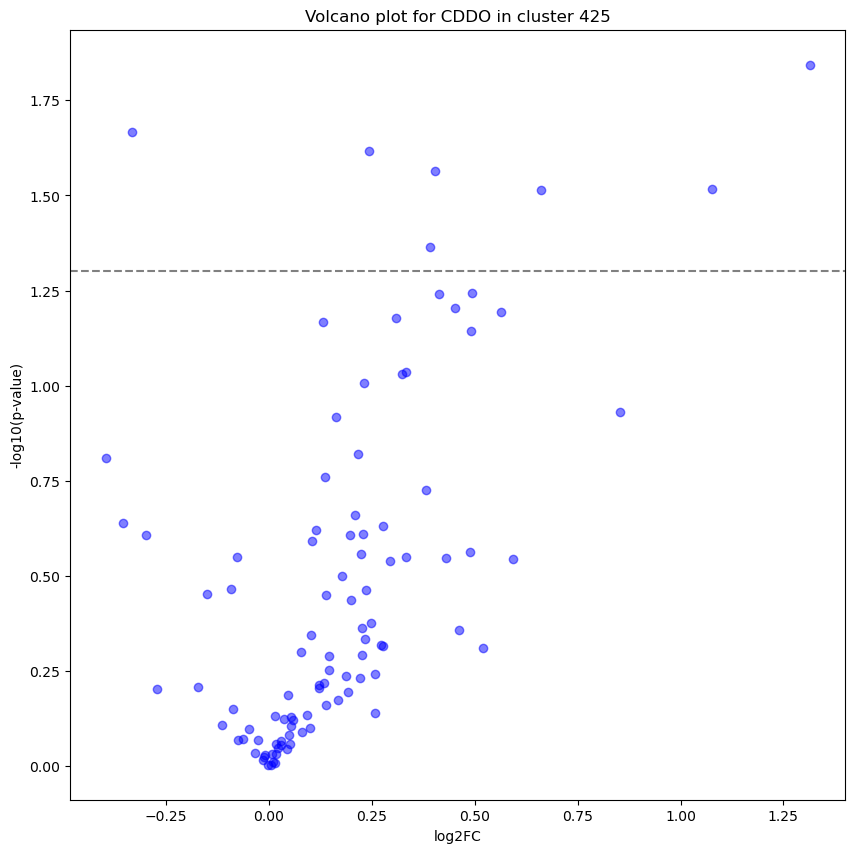

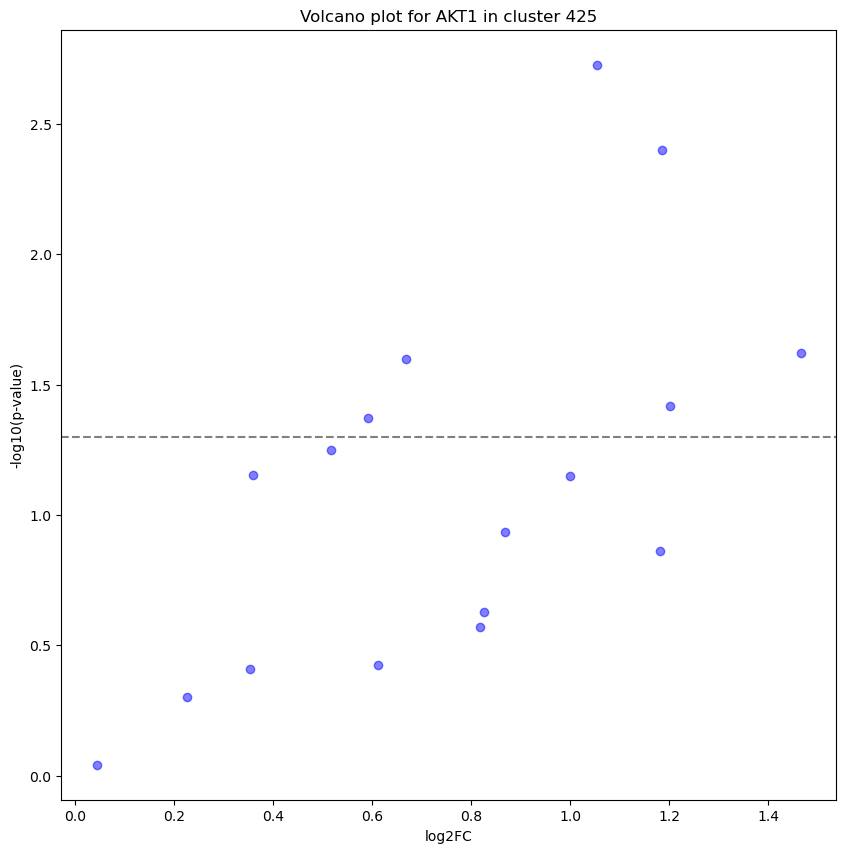

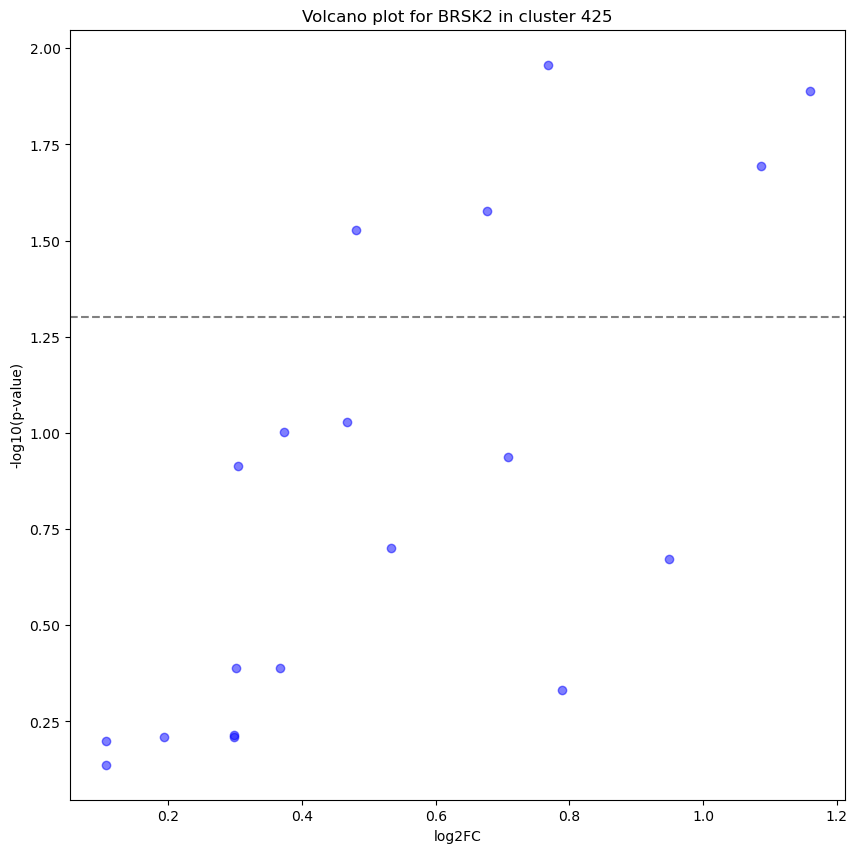

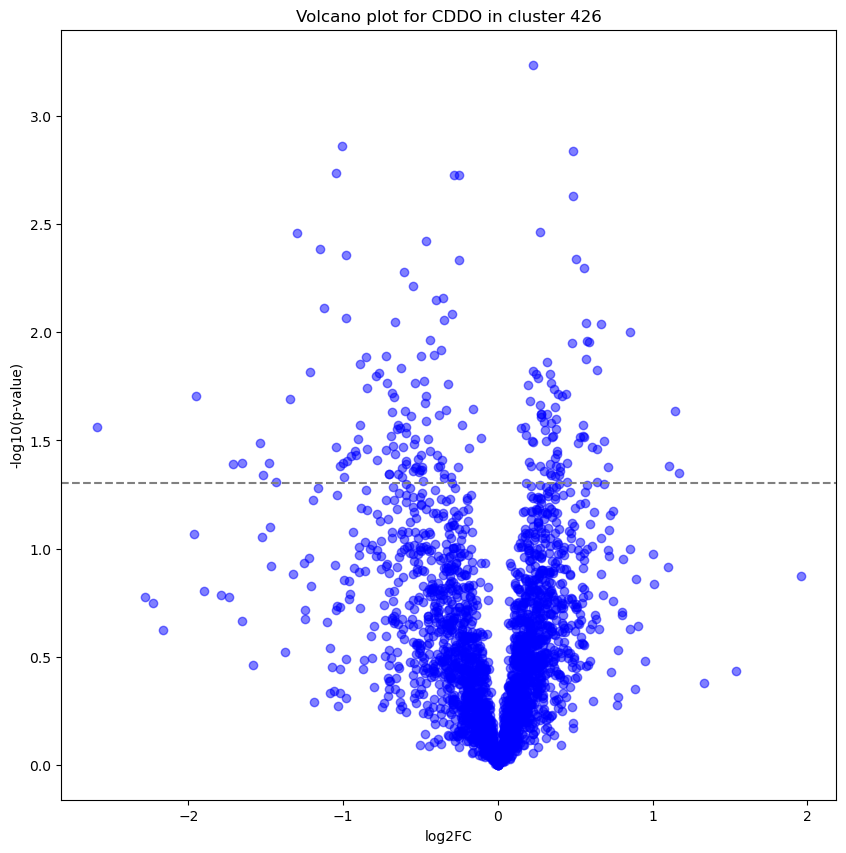

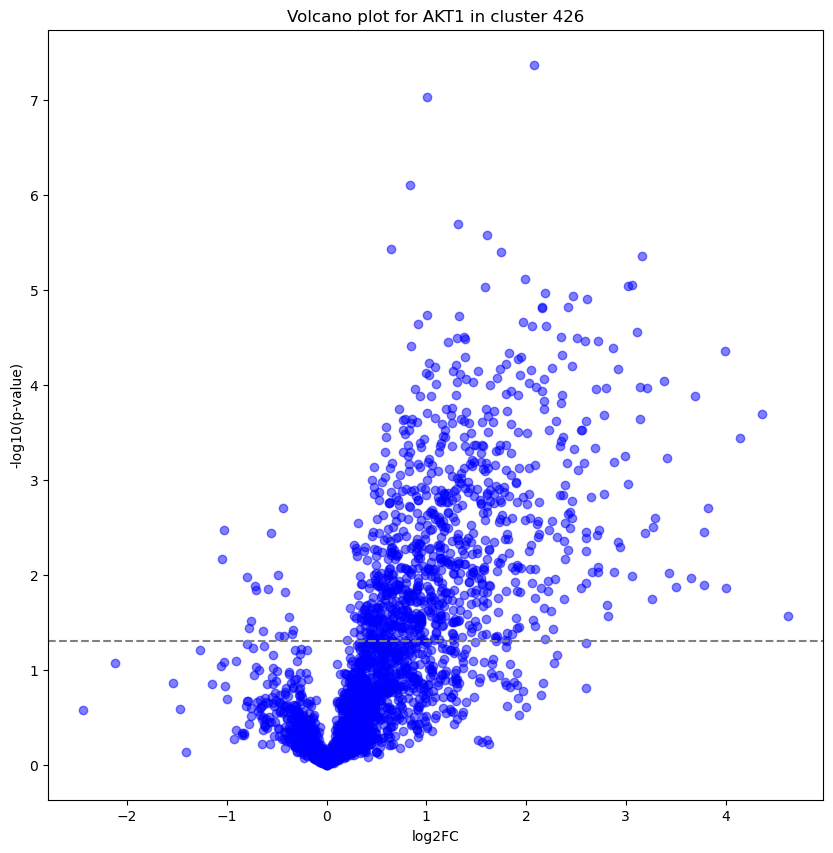

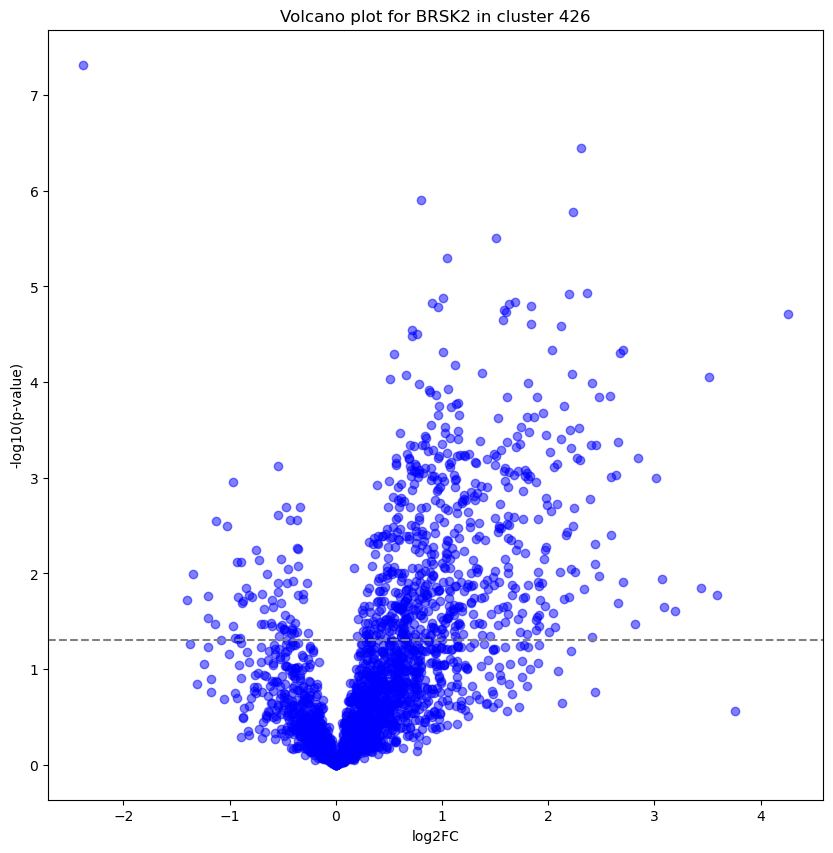

In [27]:
# I now want to make a volcano plot for each cluster and condition

# Make a list of the clusters
clusters = list(set(corr_clusters))

# Already have the comparisons dict

for cluster in clusters:
    # Only do this for clusters with more than 100 members
    if len(combined_zscore_with_fc[combined_zscore_with_fc['cluster'] == cluster]) > 100:
        for key in comparisons.keys():
            # Make a volcano plot
            fig, ax = plt.subplots(figsize=(10,10))
            # Use default colors for the clusters
            # Color the points on the volcano plot by cluster - use  the colors list
            # Don't do it with the for loop because it affects the order of the points
            scatter = ax.scatter(combined_zscore_with_fc['log2FC_' + key][combined_zscore_with_fc['cluster'] == cluster], -np.log10(combined_zscore_with_fc['pval_' + key][combined_zscore_with_fc['cluster'] == cluster]), c='blue', alpha=0.5)

            
            # Add a line for a significance threshold
            ax.axhline(y=-np.log10(0.05), color='grey', linestyle='--')

            ax.set_xlabel('log2FC')
            ax.set_ylabel('-log10(p-value)')
            ax.set_title('Volcano plot for ' + key + ' in cluster ' + str(cluster))
            fig.savefig(output_folder_path + 'cluster_' + str(cluster) + '_' + key + '_volcano.png')

In [41]:
# Now merge with the proximity data. First read in the proximity data.

prox = pd.read_csv(proximity_file_name)

# Subset the proximity data for each comparison using the gene name of the comparison
bait_data = {}

for bait in baits:
    # Subset the proximity data for the gene names
    prox_subset = prox[prox['Bait.Gene.Name'] == key]
    # Write the proximity data to a csv file
    bait_data[key] = prox_subset

# Now I want to define a function that takes in a gene name and a bait name and returns the SaintScore for that bait-gene pair using the bait_data dict

def get_saint_score(gene_name, bait_name):
    # Get the bait data for the current bait
    bait_df = bait_data[bait_name]
    # Get the saint score for the current gene
    saint_score = bait_df[bait_df['Prey.Gene.Name'] == gene_name]['SaintScore']
    # Check if the saint score is empty
    if len(saint_score) == 0:
        return 0
    else:
        return saint_score.values[0]
    
# Now I want to add a column to the combined_zscore_with_fc dataframe for each bait that contains the saint score for that bait-gene pair
for key in bait_data:
    combined_zscore_with_fc['SaintScore_' + key] = combined_zscore_with_fc['first_gene'].apply(lambda x: get_saint_score(x, key))

# Save the combined_zscore_with_fc dataframe to a csv file
combined_zscore_with_fc.to_csv(output_folder_path + 'combined_with_saint_scores.csv')

In [39]:
combined_zscore_with_fc.columns

Index(['Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes',
       'First.Protein.Description', 'Proteotypic', 'Stripped.Sequence',
       'Modified.Sequence', 'Precursor.Charge', 'Precursor.Id', 'DMSO 1',
       'DMSO 2', 'DMSO 3', 'DMSO 4', 'CDDO 1', 'CDDO 2', 'CDDO 3', 'CDDO 4',
       'dsRed 1', 'dsRed 2', 'dsRed 3', 'dsRed 4', 'AKT1 1', 'AKT1 2',
       'AKT1 3', 'AKT1 4', 'BRSK2 1', 'BRSK2 2', 'BRSK2 3', 'BRSK2 4',
       'first_id', 'start_position', 'mod_position', 'first_gene',
       'log2FC_CDDO', 'pval_CDDO', 'log2FC_AKT1', 'pval_AKT1', 'log2FC_BRSK2',
       'pval_BRSK2', 'cluster'],
      dtype='object')